<a href="https://colab.research.google.com/github/yawningwinner/dummy/blob/main/GANsHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os

DATA_DIR = '/content/Hackathon_Dataset'
print(os.listdir(DATA_DIR))

['train_images']


In [40]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [41]:
image_size = 64
batch_size = 20
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
##mean and std dev of 0.5

Normalize pixel values because it is more convinient to put in Discriminator if data is symmetric about 0(rather than being between 0 to 1)

In [42]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
## num_workers and pin memory ensure usage of multiple cores

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [43]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

To display images we need to bring them back into [0,1] range

In [44]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [45]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

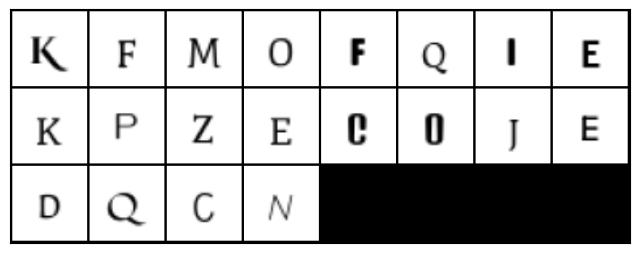

In [46]:
show_batch(train_dl)

I was not aware that pytorch requires GPU.. so was facing errors and tried "conda install -c peterjc123 pytorch-cpu" but it still gave errors on my terminal .. so found and used the below code on internet.
Class DeviceDataLoader is to move our model and data to GPU

In [47]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [48]:
device = get_default_device()
device

device(type='cuda')

In [49]:
train_dl = DeviceDataLoader(train_dl, device)

In [50]:
import torch.nn as nn

**DISCRIMINATOR**

In [51]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [52]:
##Move discriminator to gpu
discriminator = to_device(discriminator, device)

**GENERATOR**

In [56]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(128, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([20, 3, 64, 64])


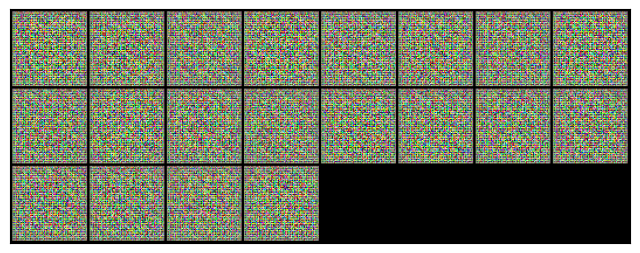

In [57]:
xb = torch.randn(batch_size, 128, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [58]:
generator = to_device(generator, device)

Training Discriminator using Binary Cross Entropy Function

In [59]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [60]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, 128, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [61]:
from torchvision.utils import save_image

In [62]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [63]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [65]:
fixed_latent = torch.randn(64, 128, 1, 1, device=device)

Saving generated-images-0000.png


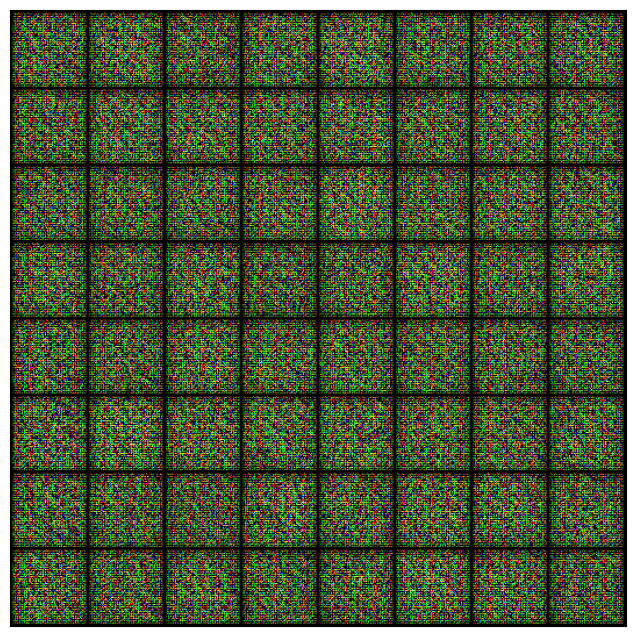

In [66]:
save_samples(0, fixed_latent)

In [67]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [68]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [69]:
lr = 0.0002
epochs = 200

In [70]:
history = fit(epochs, lr)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 7.2396, loss_d: 0.0066, real_score: 0.9971, fake_score: 0.0036
Saving generated-images-0001.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 7.9701, loss_d: 0.0036, real_score: 0.9995, fake_score: 0.0030
Saving generated-images-0002.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 7.5797, loss_d: 0.0039, real_score: 0.9980, fake_score: 0.0020
Saving generated-images-0003.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 8.5366, loss_d: 0.0022, real_score: 0.9996, fake_score: 0.0018
Saving generated-images-0004.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 6.7433, loss_d: 0.1972, real_score: 0.9902, fake_score: 0.1674
Saving generated-images-0005.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 3.8847, loss_d: 0.1285, real_score: 0.9585, fake_score: 0.0808
Saving generated-images-0006.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 6.4610, loss_d: 0.8867, real_score: 0.9960, fake_score: 0.5350
Saving generated-images-0007.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 3.4444, loss_d: 0.3674, real_score: 0.8176, fake_score: 0.1297
Saving generated-images-0008.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 3.6403, loss_d: 0.2470, real_score: 0.8767, fake_score: 0.0975
Saving generated-images-0009.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 3.3031, loss_d: 0.3949, real_score: 0.7452, fake_score: 0.0248
Saving generated-images-0010.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 4.9585, loss_d: 0.3742, real_score: 0.7431, fake_score: 0.0055
Saving generated-images-0011.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 4.4431, loss_d: 0.5136, real_score: 0.9210, fake_score: 0.3168
Saving generated-images-0012.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 5.2853, loss_d: 0.6149, real_score: 0.9150, fake_score: 0.3554
Saving generated-images-0013.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 3.6905, loss_d: 0.6892, real_score: 0.8677, fake_score: 0.3736
Saving generated-images-0014.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 3.2709, loss_d: 0.3032, real_score: 0.8124, fake_score: 0.0182
Saving generated-images-0015.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 1.3306, loss_d: 0.5577, real_score: 0.6338, fake_score: 0.0296
Saving generated-images-0016.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 3.3955, loss_d: 0.2452, real_score: 0.9362, fake_score: 0.1482
Saving generated-images-0017.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 3.8512, loss_d: 0.3814, real_score: 0.7475, fake_score: 0.0397
Saving generated-images-0018.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 2.1062, loss_d: 0.5061, real_score: 0.8030, fake_score: 0.1961
Saving generated-images-0019.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 3.0130, loss_d: 0.1370, real_score: 0.9077, fake_score: 0.0264
Saving generated-images-0020.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 0.4048, loss_d: 0.4244, real_score: 0.7626, fake_score: 0.0759
Saving generated-images-0021.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 2.5060, loss_d: 0.3196, real_score: 0.8369, fake_score: 0.1010
Saving generated-images-0022.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 4.3615, loss_d: 0.4306, real_score: 0.8972, fake_score: 0.2257
Saving generated-images-0023.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 2.5784, loss_d: 1.2013, real_score: 0.6873, fake_score: 0.4732
Saving generated-images-0024.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 3.1318, loss_d: 0.1536, real_score: 0.9739, fake_score: 0.1154
Saving generated-images-0025.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 2.0939, loss_d: 0.3567, real_score: 0.7765, fake_score: 0.0197
Saving generated-images-0026.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 3.0118, loss_d: 0.1681, real_score: 0.8968, fake_score: 0.0426
Saving generated-images-0027.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.6021, loss_d: 0.0656, real_score: 0.9539, fake_score: 0.0156
Saving generated-images-0028.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 6.9898, loss_d: 1.3613, real_score: 0.9588, fake_score: 0.6308
Saving generated-images-0029.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 4.4506, loss_d: 0.2587, real_score: 0.8410, fake_score: 0.0405
Saving generated-images-0030.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 4.6504, loss_d: 0.1428, real_score: 0.9710, fake_score: 0.0953
Saving generated-images-0031.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 3.0434, loss_d: 0.1915, real_score: 0.8641, fake_score: 0.0370
Saving generated-images-0032.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 3.2131, loss_d: 0.2730, real_score: 0.8304, fake_score: 0.0630
Saving generated-images-0033.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 3.5321, loss_d: 0.0708, real_score: 0.9978, fake_score: 0.0632
Saving generated-images-0034.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 7.4035, loss_d: 6.1538, real_score: 0.0103, fake_score: 0.0000
Saving generated-images-0035.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 5.1274, loss_d: 0.1879, real_score: 0.9900, fake_score: 0.1399
Saving generated-images-0036.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 2.6137, loss_d: 0.1762, real_score: 0.9759, fake_score: 0.1035
Saving generated-images-0037.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 4.7392, loss_d: 0.0313, real_score: 0.9763, fake_score: 0.0069
Saving generated-images-0038.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 15.8322, loss_d: 4.2788, real_score: 0.9999, fake_score: 0.9691
Saving generated-images-0039.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 1.7334, loss_d: 0.2652, real_score: 0.8377, fake_score: 0.0591
Saving generated-images-0040.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 5.1048, loss_d: 0.4248, real_score: 0.9258, fake_score: 0.2496
Saving generated-images-0041.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 4.8503, loss_d: 0.2019, real_score: 0.9571, fake_score: 0.1361
Saving generated-images-0042.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 4.0448, loss_d: 0.1429, real_score: 0.9033, fake_score: 0.0338
Saving generated-images-0043.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 2.6650, loss_d: 0.1506, real_score: 0.8854, fake_score: 0.0227
Saving generated-images-0044.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 5.4523, loss_d: 0.0107, real_score: 0.9942, fake_score: 0.0049
Saving generated-images-0045.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 4.5030, loss_d: 0.1154, real_score: 0.9355, fake_score: 0.0441
Saving generated-images-0046.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 4.8131, loss_d: 0.1708, real_score: 0.9075, fake_score: 0.0576
Saving generated-images-0047.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 8.6882, loss_d: 0.6644, real_score: 0.9918, fake_score: 0.4389
Saving generated-images-0048.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 3.7647, loss_d: 0.1025, real_score: 0.9178, fake_score: 0.0110
Saving generated-images-0049.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 1.1355, loss_d: 0.7349, real_score: 0.7102, fake_score: 0.0291
Saving generated-images-0050.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 3.3737, loss_d: 0.0851, real_score: 0.9535, fake_score: 0.0351
Saving generated-images-0051.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 4.7963, loss_d: 0.0693, real_score: 0.9674, fake_score: 0.0343
Saving generated-images-0052.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 2.5103, loss_d: 0.1875, real_score: 0.8870, fake_score: 0.0618
Saving generated-images-0053.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 4.7324, loss_d: 0.1332, real_score: 0.9906, fake_score: 0.1057
Saving generated-images-0054.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 2.8356, loss_d: 0.0396, real_score: 0.9696, fake_score: 0.0082
Saving generated-images-0055.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 4.9171, loss_d: 0.0487, real_score: 0.9589, fake_score: 0.0056
Saving generated-images-0056.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 4.9593, loss_d: 0.1970, real_score: 0.8509, fake_score: 0.0269
Saving generated-images-0057.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 5.4116, loss_d: 0.2121, real_score: 0.9569, fake_score: 0.1438
Saving generated-images-0058.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 3.8470, loss_d: 0.4587, real_score: 0.6898, fake_score: 0.0007
Saving generated-images-0059.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 6.2701, loss_d: 0.0767, real_score: 0.9688, fake_score: 0.0416
Saving generated-images-0060.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 5.8473, loss_d: 0.0121, real_score: 0.9923, fake_score: 0.0043
Saving generated-images-0061.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 6.8965, loss_d: 0.0592, real_score: 0.9972, fake_score: 0.0540
Saving generated-images-0062.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 4.7618, loss_d: 0.2069, real_score: 0.9469, fake_score: 0.1267
Saving generated-images-0063.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 4.5184, loss_d: 0.0475, real_score: 0.9843, fake_score: 0.0306
Saving generated-images-0064.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 3.6379, loss_d: 0.0347, real_score: 0.9814, fake_score: 0.0156
Saving generated-images-0065.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 0.7056, loss_d: 0.7076, real_score: 0.8376, fake_score: 0.2872
Saving generated-images-0066.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 4.0564, loss_d: 0.0537, real_score: 0.9925, fake_score: 0.0425
Saving generated-images-0067.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 5.5557, loss_d: 0.0337, real_score: 0.9767, fake_score: 0.0097
Saving generated-images-0068.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 3.6270, loss_d: 0.0679, real_score: 0.9526, fake_score: 0.0177
Saving generated-images-0069.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 2.5567, loss_d: 0.0771, real_score: 0.9941, fake_score: 0.0662
Saving generated-images-0070.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 5.7250, loss_d: 0.2015, real_score: 0.9068, fake_score: 0.0882
Saving generated-images-0071.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 3.0818, loss_d: 0.0663, real_score: 0.9934, fake_score: 0.0560
Saving generated-images-0072.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 5.7175, loss_d: 0.0768, real_score: 0.9927, fake_score: 0.0657
Saving generated-images-0073.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 3.6761, loss_d: 0.0281, real_score: 0.9910, fake_score: 0.0188
Saving generated-images-0074.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 4.9120, loss_d: 0.0307, real_score: 0.9967, fake_score: 0.0261
Saving generated-images-0075.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 9.0293, loss_d: 14.4850, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0076.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 4.5749, loss_d: 0.2712, real_score: 0.8454, fake_score: 0.0597
Saving generated-images-0077.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 3.6528, loss_d: 0.1062, real_score: 0.9793, fake_score: 0.0768
Saving generated-images-0078.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 3.7038, loss_d: 0.1013, real_score: 0.9478, fake_score: 0.0383
Saving generated-images-0079.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 5.4067, loss_d: 0.0394, real_score: 0.9916, fake_score: 0.0293
Saving generated-images-0080.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 4.4101, loss_d: 0.1733, real_score: 0.9987, fake_score: 0.1522
Saving generated-images-0081.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 4.7322, loss_d: 0.0500, real_score: 0.9845, fake_score: 0.0330
Saving generated-images-0082.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 3.4427, loss_d: 0.0325, real_score: 0.9737, fake_score: 0.0049
Saving generated-images-0083.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 4.0034, loss_d: 0.0888, real_score: 0.9608, fake_score: 0.0409
Saving generated-images-0084.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 5.0684, loss_d: 0.4172, real_score: 0.9823, fake_score: 0.2702
Saving generated-images-0085.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.9684, loss_d: 0.0544, real_score: 0.9692, fake_score: 0.0215
Saving generated-images-0086.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 4.9652, loss_d: 0.0498, real_score: 0.9744, fake_score: 0.0232
Saving generated-images-0087.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 3.7312, loss_d: 0.0502, real_score: 0.9732, fake_score: 0.0224
Saving generated-images-0088.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 7.2244, loss_d: 0.0199, real_score: 0.9962, fake_score: 0.0157
Saving generated-images-0089.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 5.7994, loss_d: 5.1069, real_score: 0.0100, fake_score: 0.0000
Saving generated-images-0090.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 4.1436, loss_d: 0.0272, real_score: 0.9988, fake_score: 0.0252
Saving generated-images-0091.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 3.6321, loss_d: 0.0096, real_score: 0.9957, fake_score: 0.0053
Saving generated-images-0092.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 5.3382, loss_d: 0.0165, real_score: 0.9958, fake_score: 0.0120
Saving generated-images-0093.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 1.6014, loss_d: 0.2739, real_score: 0.9947, fake_score: 0.2148
Saving generated-images-0094.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 4.4528, loss_d: 0.0440, real_score: 0.9725, fake_score: 0.0155
Saving generated-images-0095.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 6.8284, loss_d: 0.0126, real_score: 0.9903, fake_score: 0.0027
Saving generated-images-0096.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 5.2300, loss_d: 0.0293, real_score: 0.9950, fake_score: 0.0238
Saving generated-images-0097.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 5.7361, loss_d: 0.0145, real_score: 0.9917, fake_score: 0.0061
Saving generated-images-0098.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 0.7768, loss_d: 1.0609, real_score: 0.9101, fake_score: 0.3885
Saving generated-images-0099.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 2.3846, loss_d: 0.1692, real_score: 0.9186, fake_score: 0.0699
Saving generated-images-0100.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 3.8208, loss_d: 0.0867, real_score: 0.9419, fake_score: 0.0221
Saving generated-images-0101.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 4.6118, loss_d: 0.0551, real_score: 0.9926, fake_score: 0.0459
Saving generated-images-0102.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 4.4424, loss_d: 0.0698, real_score: 0.9775, fake_score: 0.0448
Saving generated-images-0103.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 3.7517, loss_d: 0.0150, real_score: 0.9953, fake_score: 0.0102
Saving generated-images-0104.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 4.2510, loss_d: 0.0131, real_score: 0.9967, fake_score: 0.0097
Saving generated-images-0105.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 4.2222, loss_d: 0.0090, real_score: 0.9958, fake_score: 0.0048
Saving generated-images-0106.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 5.6415, loss_d: 0.0413, real_score: 0.9995, fake_score: 0.0396
Saving generated-images-0107.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 0.4099, loss_d: 0.9464, real_score: 0.6464, fake_score: 0.1461
Saving generated-images-0108.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 0.3063, loss_d: 0.3132, real_score: 0.7675, fake_score: 0.0065
Saving generated-images-0109.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 5.3149, loss_d: 0.0219, real_score: 0.9959, fake_score: 0.0173
Saving generated-images-0110.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 7.1976, loss_d: 0.0415, real_score: 0.9691, fake_score: 0.0092
Saving generated-images-0111.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 5.1014, loss_d: 0.0322, real_score: 0.9774, fake_score: 0.0091
Saving generated-images-0112.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 3.7805, loss_d: 0.0594, real_score: 0.9455, fake_score: 0.0011
Saving generated-images-0113.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 3.7858, loss_d: 0.0346, real_score: 0.9727, fake_score: 0.0066
Saving generated-images-0114.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 5.7282, loss_d: 0.0140, real_score: 0.9910, fake_score: 0.0049
Saving generated-images-0115.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 5.5551, loss_d: 0.1971, real_score: 0.9450, fake_score: 0.1064
Saving generated-images-0116.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 6.9551, loss_d: 0.0236, real_score: 0.9917, fake_score: 0.0149
Saving generated-images-0117.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 1.8243, loss_d: 0.3387, real_score: 0.8163, fake_score: 0.1101
Saving generated-images-0118.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 5.8395, loss_d: 0.0199, real_score: 0.9972, fake_score: 0.0169
Saving generated-images-0119.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 3.4386, loss_d: 0.0737, real_score: 0.9961, fake_score: 0.0601
Saving generated-images-0120.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 4.9572, loss_d: 0.1037, real_score: 0.9814, fake_score: 0.0745
Saving generated-images-0121.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 2.6351, loss_d: 0.0822, real_score: 0.9958, fake_score: 0.0727
Saving generated-images-0122.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 5.4755, loss_d: 0.0117, real_score: 0.9906, fake_score: 0.0021
Saving generated-images-0123.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 6.3679, loss_d: 0.0102, real_score: 0.9968, fake_score: 0.0069
Saving generated-images-0124.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 9.2968, loss_d: 0.0146, real_score: 0.9861, fake_score: 0.0005
Saving generated-images-0125.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 6.6629, loss_d: 0.0114, real_score: 0.9966, fake_score: 0.0079
Saving generated-images-0126.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 6.7455, loss_d: 6.7777, real_score: 0.0034, fake_score: 0.0000
Saving generated-images-0127.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 4.3040, loss_d: 0.0696, real_score: 0.9652, fake_score: 0.0327
Saving generated-images-0128.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.2095, loss_d: 0.1121, real_score: 0.9052, fake_score: 0.0091
Saving generated-images-0129.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 5.3822, loss_d: 0.0530, real_score: 0.9960, fake_score: 0.0468
Saving generated-images-0130.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 1.9719, loss_d: 3.5662, real_score: 0.9947, fake_score: 0.9450
Saving generated-images-0131.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 1.9701, loss_d: 0.2607, real_score: 0.9484, fake_score: 0.1561
Saving generated-images-0132.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 3.3471, loss_d: 0.3324, real_score: 0.7389, fake_score: 0.0093
Saving generated-images-0133.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 9.5305, loss_d: 0.4068, real_score: 0.9759, fake_score: 0.2926
Saving generated-images-0134.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 4.9007, loss_d: 0.0920, real_score: 0.9730, fake_score: 0.0603
Saving generated-images-0135.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 3.8015, loss_d: 0.0222, real_score: 0.9993, fake_score: 0.0210
Saving generated-images-0136.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 5.5900, loss_d: 0.0338, real_score: 0.9984, fake_score: 0.0314
Saving generated-images-0137.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 6.2326, loss_d: 0.0474, real_score: 0.9866, fake_score: 0.0328
Saving generated-images-0138.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 5.4296, loss_d: 0.0186, real_score: 0.9835, fake_score: 0.0019
Saving generated-images-0139.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 2.1028, loss_d: 0.2537, real_score: 0.8703, fake_score: 0.0735
Saving generated-images-0140.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 2.3287, loss_d: 0.3276, real_score: 0.7840, fake_score: 0.0415
Saving generated-images-0141.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.8812, loss_d: 0.2849, real_score: 0.9788, fake_score: 0.2014
Saving generated-images-0142.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 4.1479, loss_d: 0.0649, real_score: 0.9529, fake_score: 0.0156
Saving generated-images-0143.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 4.0124, loss_d: 0.0163, real_score: 0.9985, fake_score: 0.0146
Saving generated-images-0144.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 4.6988, loss_d: 0.0181, real_score: 0.9952, fake_score: 0.0131
Saving generated-images-0145.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.1731, loss_d: 0.0108, real_score: 0.9968, fake_score: 0.0076
Saving generated-images-0146.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 2.4747, loss_d: 0.9844, real_score: 0.7837, fake_score: 0.3912
Saving generated-images-0147.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 2.6715, loss_d: 0.2222, real_score: 0.8459, fake_score: 0.0350
Saving generated-images-0148.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 3.8603, loss_d: 0.1324, real_score: 0.9076, fake_score: 0.0160
Saving generated-images-0149.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 7.2035, loss_d: 0.1625, real_score: 0.9978, fake_score: 0.1307
Saving generated-images-0150.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 5.3911, loss_d: 0.0788, real_score: 0.9810, fake_score: 0.0531
Saving generated-images-0151.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 5.1049, loss_d: 0.0933, real_score: 0.9906, fake_score: 0.0770
Saving generated-images-0152.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 6.2986, loss_d: 0.0440, real_score: 0.9986, fake_score: 0.0411
Saving generated-images-0153.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.6535, loss_d: 0.0220, real_score: 0.9987, fake_score: 0.0203
Saving generated-images-0154.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 5.3346, loss_d: 0.0090, real_score: 0.9986, fake_score: 0.0076
Saving generated-images-0155.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 3.2644, loss_d: 0.2162, real_score: 0.9715, fake_score: 0.1590
Saving generated-images-0156.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 4.3178, loss_d: 0.0415, real_score: 0.9984, fake_score: 0.0382
Saving generated-images-0157.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.8429, loss_d: 0.0152, real_score: 0.9923, fake_score: 0.0074
Saving generated-images-0158.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 5.1578, loss_d: 0.0492, real_score: 0.9965, fake_score: 0.0441
Saving generated-images-0159.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 5.1345, loss_d: 0.0261, real_score: 0.9803, fake_score: 0.0055
Saving generated-images-0160.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 4.6635, loss_d: 0.0277, real_score: 0.9951, fake_score: 0.0221
Saving generated-images-0161.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 5.4946, loss_d: 0.0123, real_score: 0.9976, fake_score: 0.0097
Saving generated-images-0162.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 6.7963, loss_d: 0.0036, real_score: 0.9987, fake_score: 0.0023
Saving generated-images-0163.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 6.7452, loss_d: 0.0186, real_score: 0.9966, fake_score: 0.0151
Saving generated-images-0164.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 9.2528, loss_d: 0.0499, real_score: 0.9897, fake_score: 0.0378
Saving generated-images-0165.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 19.0755, loss_d: 0.0074, real_score: 0.9926, fake_score: 0.0000
Saving generated-images-0166.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 7.7458, loss_d: 0.0012, real_score: 0.9997, fake_score: 0.0009
Saving generated-images-0167.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 11.1704, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0000
Saving generated-images-0168.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 7.9557, loss_d: 0.0024, real_score: 0.9984, fake_score: 0.0008
Saving generated-images-0169.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 8.0469, loss_d: 0.0018, real_score: 0.9996, fake_score: 0.0013
Saving generated-images-0170.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 6.9280, loss_d: 0.0025, real_score: 0.9996, fake_score: 0.0020
Saving generated-images-0171.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 9.3846, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001
Saving generated-images-0172.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 6.2001, loss_d: 0.0049, real_score: 0.9998, fake_score: 0.0047
Saving generated-images-0173.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 8.1650, loss_d: 0.0006, real_score: 0.9998, fake_score: 0.0004
Saving generated-images-0174.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 7.9941, loss_d: 0.0007, real_score: 0.9997, fake_score: 0.0005
Saving generated-images-0175.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 6.7828, loss_d: 0.0052, real_score: 0.9999, fake_score: 0.0051
Saving generated-images-0176.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 11.9202, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0000
Saving generated-images-0177.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 7.3685, loss_d: 0.0015, real_score: 0.9997, fake_score: 0.0012
Saving generated-images-0178.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 8.8046, loss_d: 0.0010, real_score: 0.9992, fake_score: 0.0002
Saving generated-images-0179.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 8.5950, loss_d: 0.0009, real_score: 0.9994, fake_score: 0.0003
Saving generated-images-0180.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 6.4279, loss_d: 0.0040, real_score: 0.9999, fake_score: 0.0039
Saving generated-images-0181.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 8.5665, loss_d: 0.0005, real_score: 0.9997, fake_score: 0.0003
Saving generated-images-0182.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 7.8552, loss_d: 0.0007, real_score: 0.9998, fake_score: 0.0005
Saving generated-images-0183.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 9.5457, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0184.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 6.5187, loss_d: 0.0054, real_score: 0.9971, fake_score: 0.0025
Saving generated-images-0185.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 9.6812, loss_d: 0.0007, real_score: 0.9994, fake_score: 0.0001
Saving generated-images-0186.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 9.1039, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0187.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 9.9734, loss_d: 0.0002, real_score: 0.9999, fake_score: 0.0001
Saving generated-images-0188.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 8.6476, loss_d: 0.0004, real_score: 0.9998, fake_score: 0.0002
Saving generated-images-0189.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 10.5310, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000
Saving generated-images-0190.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 7.3437, loss_d: 0.0010, real_score: 0.9999, fake_score: 0.0009
Saving generated-images-0191.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 8.3606, loss_d: 0.0005, real_score: 0.9997, fake_score: 0.0003
Saving generated-images-0192.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 7.3530, loss_d: 0.0011, real_score: 0.9998, fake_score: 0.0009
Saving generated-images-0193.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 8.7463, loss_d: 0.0004, real_score: 0.9997, fake_score: 0.0002
Saving generated-images-0194.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 7.5218, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0007
Saving generated-images-0195.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 9.8872, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0196.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 8.3633, loss_d: 0.0009, real_score: 0.9994, fake_score: 0.0003
Saving generated-images-0197.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 9.7812, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0198.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 9.3442, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0199.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 8.2465, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0004
Saving generated-images-0200.png


In [71]:
losses_g, losses_d, real_scores, fake_scores = history

In [72]:
losses_g

[7.239585876464844,
 7.9700541496276855,
 7.579682350158691,
 8.53656005859375,
 6.743310451507568,
 3.884683609008789,
 6.461033821105957,
 3.4443843364715576,
 3.6402976512908936,
 3.3031411170959473,
 4.9585394859313965,
 4.443079948425293,
 5.285279750823975,
 3.6904945373535156,
 3.2708733081817627,
 1.3306440114974976,
 3.395465135574341,
 3.8512253761291504,
 2.1062095165252686,
 3.013031482696533,
 0.4048081934452057,
 2.5060226917266846,
 4.361489295959473,
 2.5783915519714355,
 3.131826639175415,
 2.093877077102661,
 3.0118117332458496,
 3.6021220684051514,
 6.9897589683532715,
 4.4506402015686035,
 4.650355815887451,
 3.043424367904663,
 3.2131288051605225,
 3.532142400741577,
 7.4035234451293945,
 5.1274094581604,
 2.6136538982391357,
 4.739179611206055,
 15.832199096679688,
 1.7334396839141846,
 5.104840278625488,
 4.850347518920898,
 4.044770240783691,
 2.6649515628814697,
 5.45234489440918,
 4.5030317306518555,
 4.813066005706787,
 8.688180923461914,
 3.764724016189575,


In [73]:
from IPython.display import Image

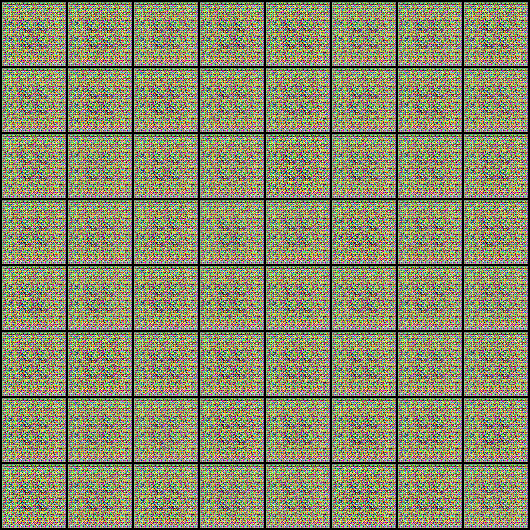

In [74]:
Image('./generated/generated-images-0001.png')

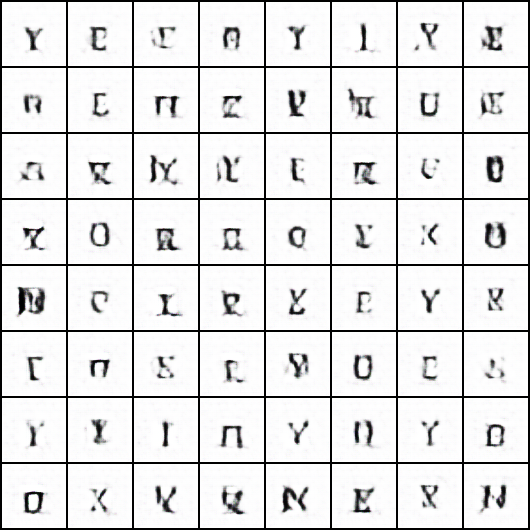

In [75]:
Image('./generated/generated-images-0050.png')

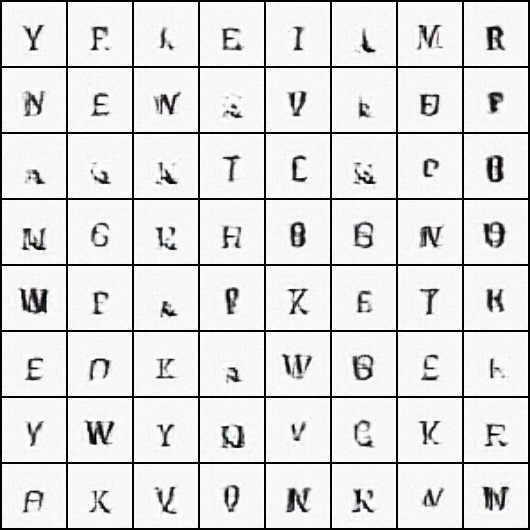

In [84]:
Image('./generated/generated-images-0160.png')

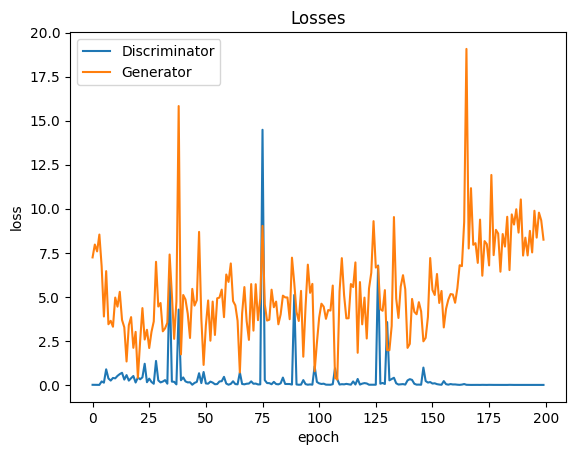

In [77]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');